In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Restaurant Category Classification
---

### Goals:
Given a set of business categories for each of our restaurants, for example:


```
American(new), burgers, Restaurant, Food, Catering Services
```

Classify each restaurant into one of several restaurant categories, for example:

```
   Fast Food
   Mexican
   Chinese
   American
```
    
    
### Why:

This allows us to investigate interesting questions, such as:

* Do cuisine types cluster in different locations around Las Vegas?
* Are there locations where cuisine types with good star reviews cluster?
* What are popular cuisine types in Vegas?


### Workflow:
1. Create a corpus containing our business categories.
2. Assign each business category a score using term frequency-inverse document frequency (tf-idf) method.
3. Use k-means clustering to cluser business categories based on their tf-idf score.
4. Collect the highest tf-idf scored term in each cluster and use it as our business category label.

## Load the restaurant data
---
**IMPORTANT NOTE:**

This json uses the **CLEANED** restaurant dataset generated by running the pre-processing notebook: 

**..Preprocessing/Data Reduction/DataReduction_Businesses.ipynb**

This notebook must be run in order to generate the cleaned business json file. Once complete, it's path should be:

**..Preprocessing/Data Reduction/cleaned_restaurants.json**

In [24]:
# Load the cleaned business json
PATH = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..') + "/Preprocessing/Data Reduction/cleaned_restaurants.json")
cleanedRestaurants = pd.read_json(PATH, orient='records')

## Collect and transform our business category lists
---
This code will collect all our restaurant business categories and use them to populate a word frequency matrix to be used for TDIF and K-Means clustering.

In [25]:
# ------------------------------------------------------------------------------
#  Prepare a word frequency matrix from our restaurant categories
# ------------------------------------------------------------------------------

# Create a vectorizer instance (i.e. a blank word frequency matrix) using TfidVectorizer class
vectorizer = TfidfVectorizer(stop_words='english')

# Convert the restaurant categories to a text corpus consisting of all restaurant categories
corpus = cleanedRestaurants[['categories']].to_string(index=False).replace(" ", "").split('\n')

# Populate the word frequency matrix using our text corpus
X = vectorizer.fit_transform(corpus)

## Determine k for our k-means clustering
---

The business category list is quite large and varied (printer services, gas stations, pizza, etc.) so we need to find an optimal valule for k when we peform our k means clustering.

#### Sum-squred error (SSE):
* This is the sum of the squared difference between each point being clustered and its mean. 
* It's used as a measure of the variation in a cluster, for example:

```
SSE = 0 if all cluster points are equal
```

* Determine k by plotting SSE over a range of k and select k where the SSE approaches a minima
* In the library `sklearn.cluster.KMeans` this can be done easily with the `intertia_` method

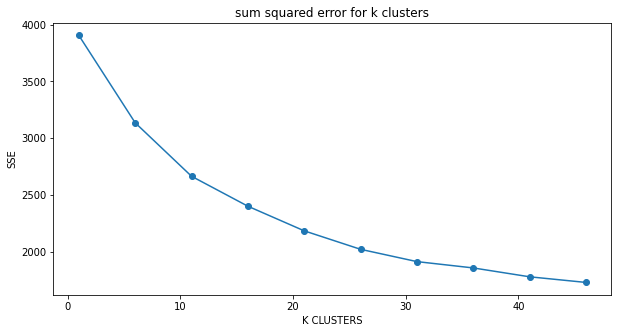

CPU times: user 7min 37s, sys: 1min 36s, total: 9min 14s
Wall time: 1min 14s


In [26]:
%%time
# ------------------------------------------------------------------------------
#  Select the number of clusters for k-means with minimal sum squared error
# ------------------------------------------------------------------------------

# Set the number of k values to test
k_test_val = 50

# Create an empty list for collecting SSE for different values of k
SSE = []

# Compute SSE for each value of k
for k in range(1, k_test_val, 5):
    SSE.append(KMeans(n_clusters=k).fit(X).inertia_)

# Plot SSE for each value of k
f, ax = plt.subplots(figsize=(10,5))
ax.plot(range(1, k_test_val, 5), SSE, marker='o')

# Labels for the plot
ax.set_xlabel('K CLUSTERS')
ax.set_ylabel('SSE')
ax.set_title('sum squared error for k clusters')
plt.show()

### Conclusion:
Set **k=30** when clustering our restaurant categories.

## Run K-means clustering using restaurant category text IDF scores 
---
This code runs K means using the k value from our SSE graph above and our restaurant category IDF scores.

In [27]:
%%time
# ------------------------------------------------------------------------------
#  Use K-means to cluster restaurant category words by IDF score
# ------------------------------------------------------------------------------

# Run K-means clustering for k = 30 on our IDF scores (X)
model = KMeans(n_clusters=30, init='k-means++')
model.fit(X)

# Collect cluster labels
labels = model.labels_

CPU times: user 1min 8s, sys: 9.91 s, total: 1min 18s
Wall time: 10.4 s


## Visualize restaurant category word clusters 
---

* This code transforms our IDF scores using t-distributed stochastic neighbor embedding (t-SNE).
* t-SNE is useful for visualizing clusters by reducing dimensionality while keeping similarities between data points within clusters intact.

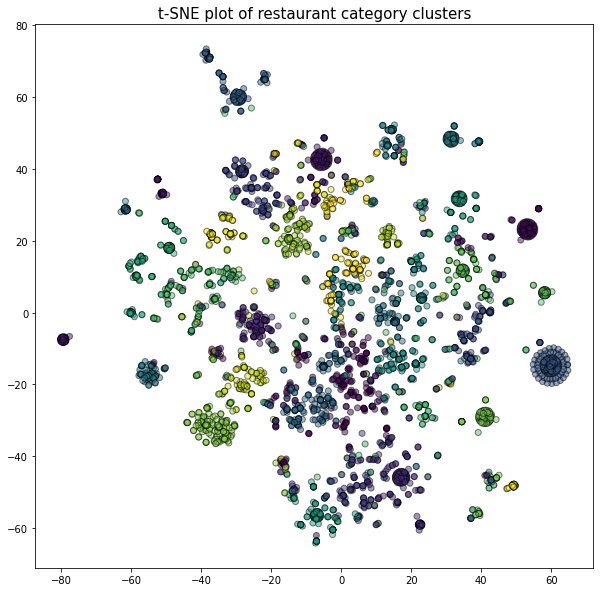

CPU times: user 1min 57s, sys: 872 ms, total: 1min 58s
Wall time: 16.5 s


In [28]:
%%time
# ----------------------------------------------------------------------------------------------
#  Visualize clusters with t-distributed stochastic neighbor embedding (t-SNE)
# 
#  Source: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
#  Source: https://www.kaggle.com/aussie84/clustering-with-kmeans-pca-tsne
# ----------------------------------------------------------------------------------------------

# Run TSNE with our word frequency matrix
tsne = TSNE().fit_transform(X.todense())

# Create a dataframe containing TSNE results
tsne_df = pd.DataFrame(tsne)

# Add a column with k-means cluster labels
tsne_df['clusters'] = labels

# Label columns in the dataframe for plotting
tsne_df.columns = ['x', 'y', 'clusters']

# Plot the restaurant category clusters
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(data=tsne_df, x='x', y='y', c='clusters', alpha=0.5, ec='black')
ax.set_title('t-SNE plot of restaurant category clusters', fontdict={'fontsize': 15})
plt.show()

## Identify the highest IDF valued text in each cluster 
---
This code loops through each cluster, sorts terms by IDF value, then collects the highest IDF valued term.

In [30]:
# ----------------------------------------------------------------------------------------------
#  Label each cluster with the highest IDF valued terms in each cluster
# ----------------------------------------------------------------------------------------------

# Get the terms selected from TF-IDF
terms = vectorizer.get_feature_names()

# Create a dataframe with our word frequency matrix grouped by cluster label
categories_df = pd.DataFrame(X.todense()).groupby(labels).mean()

# Set our k value (from our SSE graph)
k = 30

# Collect the highest IDF valued term for each cluster label
cluster_ids = []
for i, row in categories_df.iterrows():
    sorted_IDF_terms = [terms[t] for t in np.argsort(row)]   # Sorts from lowest to highest
    cluster_ids.append(sorted_IDF_terms[-1])                 # Collect the highest IDF term

# List the highest IDF valued terms in each cluster. There should be k=30 of them.
assert(len(cluster_ids) == k)
print(cluster_ids)

['nightlife', 'pizza', 'coffee', 'caterers', 'chinese', 'asianfusion', 'icecream', 'chickenwings', 'mexican', 'conveniencestores', 'bars', 'american', 'hotels', 'sandwiches', 'american', 'steakhouses', 'sushibars', 'burgers', 'shopping', 'grocery', 'seafood', 'specialtyfood', 'italian', 'fastfood', 'beer', 'juicebars', 'diners', 'entertainment', 'bakeries', 'breakfast']


## Predict and label restaurant categories
---
This code inserts a new column into our `cleanedRestaurants` that will be populated with a restaurant category label. In order to do this, each restaurant category list is transformed into a corpus, and then its membership to a IDF cluster is determined. Then, using the cluster labels in the previous cell, we assign a category label to the restaurant. This category label is the text with the highest IDF score in the cluster.

In [31]:
%%time
# ----------------------------------------------------------------------------------------------
#  Assign restaurant categories using cluster labels
# ----------------------------------------------------------------------------------------------

# Insert a new row into the cleanedRestaurants dataframe for the restaurant 'id'
if 'restaurant_type' not in cleanedRestaurants:
    cleanedRestaurants.insert(15, 'restaurant_type', np.nan)

# Predict the restaurant type by assigning it to a cluster
for i, row in cleanedRestaurants.iterrows():
    
    # Get the business category list from the row
    row_business_categories = row['categories'].lower().replace(' ', '').split(',')

    # Populate a word frequency matrix with the business category list
    X = vectorizer.transform(row_business_categories)
    
    # Predict the cluster these restaurant categories belong to
    predicted_cluster = model.predict(X)
    
    # Label the cluster using the highest IDF valued term
    category_label = cluster_ids[predicted_cluster[0]]
    
    # Insert the restaurant category into dataframe
    cleanedRestaurants.loc[i, 'restaurant_type'] = category_label

# List the restaurant categories alongside their new restaurant type labels
cleanedRestaurants[['categories', 'restaurant_type']]

CPU times: user 4.1 s, sys: 92.6 ms, total: 4.19 s
Wall time: 4.2 s


,categories,restaurant_type
0,"Mexican, Restaurants, Fast Food",mexican
1,"Burgers, Restaurants, American (Traditional), ...",burgers
2,"Fast Food, Restaurants",fastfood
3,"Specialty Food, Health Markets, Food, Shopping...",specialtyfood
4,"Pizza, Salad, Burgers, Restaurants",pizza
...,...,...
4269,"American (New), Karaoke, Restaurants, Lounges,...",american
4270,"Salad, Sushi Bars, Japanese, Restaurants, Asia...",specialtyfood
4271,"Delis, Restaurants, Sandwiches, Food, Pizza",sandwiches
4272,"Pizza, Italian, Restaurants",pizza


The above dataframe snippet shows the new column `restaurant_type` which contains the predicted type of restaurant based on its yelp category list.

## Restaurant category frequency in Las Vegas
---
Now we can work on other interesting questions involving the locations, star reviews, and review counts of restaurants in different categories.

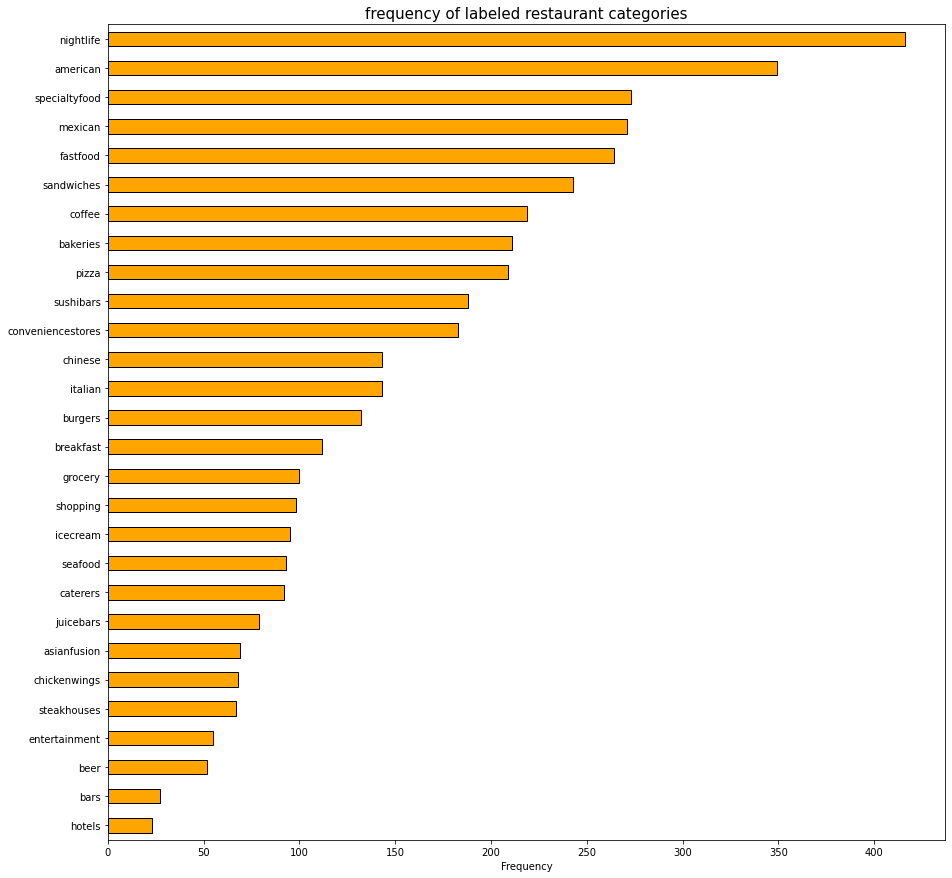

In [35]:
# Now we can look at the frequency of each restaurant type 
fig, ax = plt.subplots()
cleanedRestaurants['restaurant_type'].value_counts().plot(ax=ax, kind='barh', color='orange', ec='black', figsize=(15, 15))
ax.set_xlabel('Frequency')
ax.set_title('frequency of labeled restaurant categories', fontdict={'fontsize': 15})
plt.gca().invert_yaxis()
plt.show()

## Export the labeled restaurant categories as a json
---

In [36]:
# Export to JSON
cleanedRestaurants.to_json(r'labeled_cleaned_restaurants.json')